# Non-adiabatic Quantum Quenches using IBM's Qiskit.

### Noise/Noiseless simulations

In [30]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector, Pauli
import numpy as np
import matplotlib.pyplot as plt

###########################################################
#               SIMULATION WITHOUT NOISE
###########################################################

def tfim_circuit(num_qubits, J, h, trotter_steps=1, delta_t=0.1):
    """Create the TFIM circuit (unchanged from your original)"""
    qc = QuantumCircuit(num_qubits)
    theta_zz = -2 * J * delta_t
    theta_x = 2 * h * delta_t

    for _ in range(trotter_steps):
        # ZZ interactions
        for i in range(num_qubits - 1):
            qc.rzz(theta_zz, i, i + 1)
        qc.rzz(theta_zz, num_qubits - 1, 0)  # Periodic boundary
        qc.barrier()
        # X rotations
        for i in range(num_qubits):
            qc.rx(theta_x, i)
        qc.barrier()
    return qc

def calculate_magnetization(statevector, num_qubits):
    """Calculate average magnetization (same implementation as noisy version)"""
    avg_mz = 0
    for i in range(num_qubits):
        pauli_z = Pauli('I'*i + 'Z' + 'I'*(num_qubits-1-i))
        avg_mz += statevector.expectation_value(pauli_z)
    return avg_mz.real / num_qubits

# Parameters (unchanged)
J = 1
h_f = 2.0
delta_t = 0.05
max_time = 20.0
time_steps = np.arange(0, max_time, delta_t)
system_sizes = [6, 10, 14]

# Simulation (now following the noisy version's structure)
simulator = Aer.get_backend('statevector_simulator')
results_noiseless = {}

for num_qubits in system_sizes:
    print(f"Simulating N={num_qubits}")
    mag_vals = []
    
    for t in time_steps:
        qc = QuantumCircuit(num_qubits)
        initial_state = Statevector.from_label('0' * num_qubits)
        qc.set_statevector(initial_state)
        
        # Time evolution
        trotter_steps = int(t / delta_t)
        qc.compose(tfim_circuit(num_qubits, J, h_f, trotter_steps, delta_t), inplace=True)
        
        # Simulate without noise
        result = simulator.run(qc).result()
        statevector = Statevector(result.get_statevector())
        
        mag_vals.append(calculate_magnetization(statevector, num_qubits))
    
    results_noiseless[num_qubits] = mag_vals


Simulating N=6
Simulating N=10
Simulating N=14


In [ ]:
#######################################################
#           IMPORTING NOISE MODEL
#######################################################

from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum", #on open plan, so use cloud
                               token = "33cd49f3ef12e9289743171751a7223db0cae0aa8bd9f0257c3981aed57a2528946468154d2025cc6b4b8689e79a2dbd8a446e0f9ebd9b8e8f63796b63f7fb1d")
backend = service.backend("ibm_brisbane")

In [88]:
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

noise_model = NoiseModel.from_backend(backend)

In [113]:

# Get average single-qubit error (p1)
sx_error = backend.target['sx'][(0,)].error      # Example: Qubit 0
x_error = backend.target['x'][(0,)].error        # Example: Qubit 0
p1 = (sx_error + x_error) / 2                    # Average of single-qubit gates

# Get average two-qubit error (p2) from ECR
ecr_errors = [props.error for props in backend.target['ecr'].values()]
p2 = sum(ecr_errors) / len(ecr_errors)           # Average ECR error

print(f"p1 (avg single-qubit error): {p1:.6f}")
print(f"p2 (avg ECR error): {p2:.6f}")

p1 (avg single-qubit error): 0.000128
p2 (avg ECR error): 0.030446


In [161]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

#######################################################
#           SIMULATION WITH NOISE 
#######################################################


def create_light_noise_model():
    noise_model = NoiseModel()
    
    # Very small depolarizing errors only
    p1 = 0.0002  # Single-qubit error (0.02%)
    p2 = 0.001   # Two-qubit error (0.1%)
    
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(p1, 1), ['rx'])
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(p2, 2), ['rzz'])
    
    return noise_model


def calculate_magnetization(statevector, num_qubits):
    """Calculate average magnetization from statevector"""
    avg_mz = 0
    for i in range(num_qubits):
        pauli_z = Pauli('I'*i + 'Z' + 'I'*(num_qubits-1-i))
        avg_mz += statevector.expectation_value(pauli_z)
    return avg_mz.real / num_qubits


# Create very light noise model
noise_model = create_light_noise_model()
simulator = Aer.get_backend('statevector_simulator')

# Simulation
results_noisy = {}
for num_qubits in system_sizes:
    print(f"Simulating N={num_qubits}")
    mag_vals_noisy = []
    
    for t in time_steps:
        qc = QuantumCircuit(num_qubits)
        initial_state = Statevector.from_label('0' * num_qubits)
        qc.set_statevector(initial_state)
        
        # Time evolution
        trotter_steps = int(t / delta_t)
        qc.compose(tfim_circuit(num_qubits, J, h_f, trotter_steps, delta_t), inplace=True)
        
        # Simulate with noise
        result = simulator.run(qc, noise_model=noise_model).result()
        statevector = Statevector(result.get_statevector())
        
        mag_vals_noisy.append(calculate_magnetization(statevector, num_qubits))
    
    results_noisy[num_qubits] = mag_vals_noisy


Simulating N=6
Simulating N=10
Simulating N=14


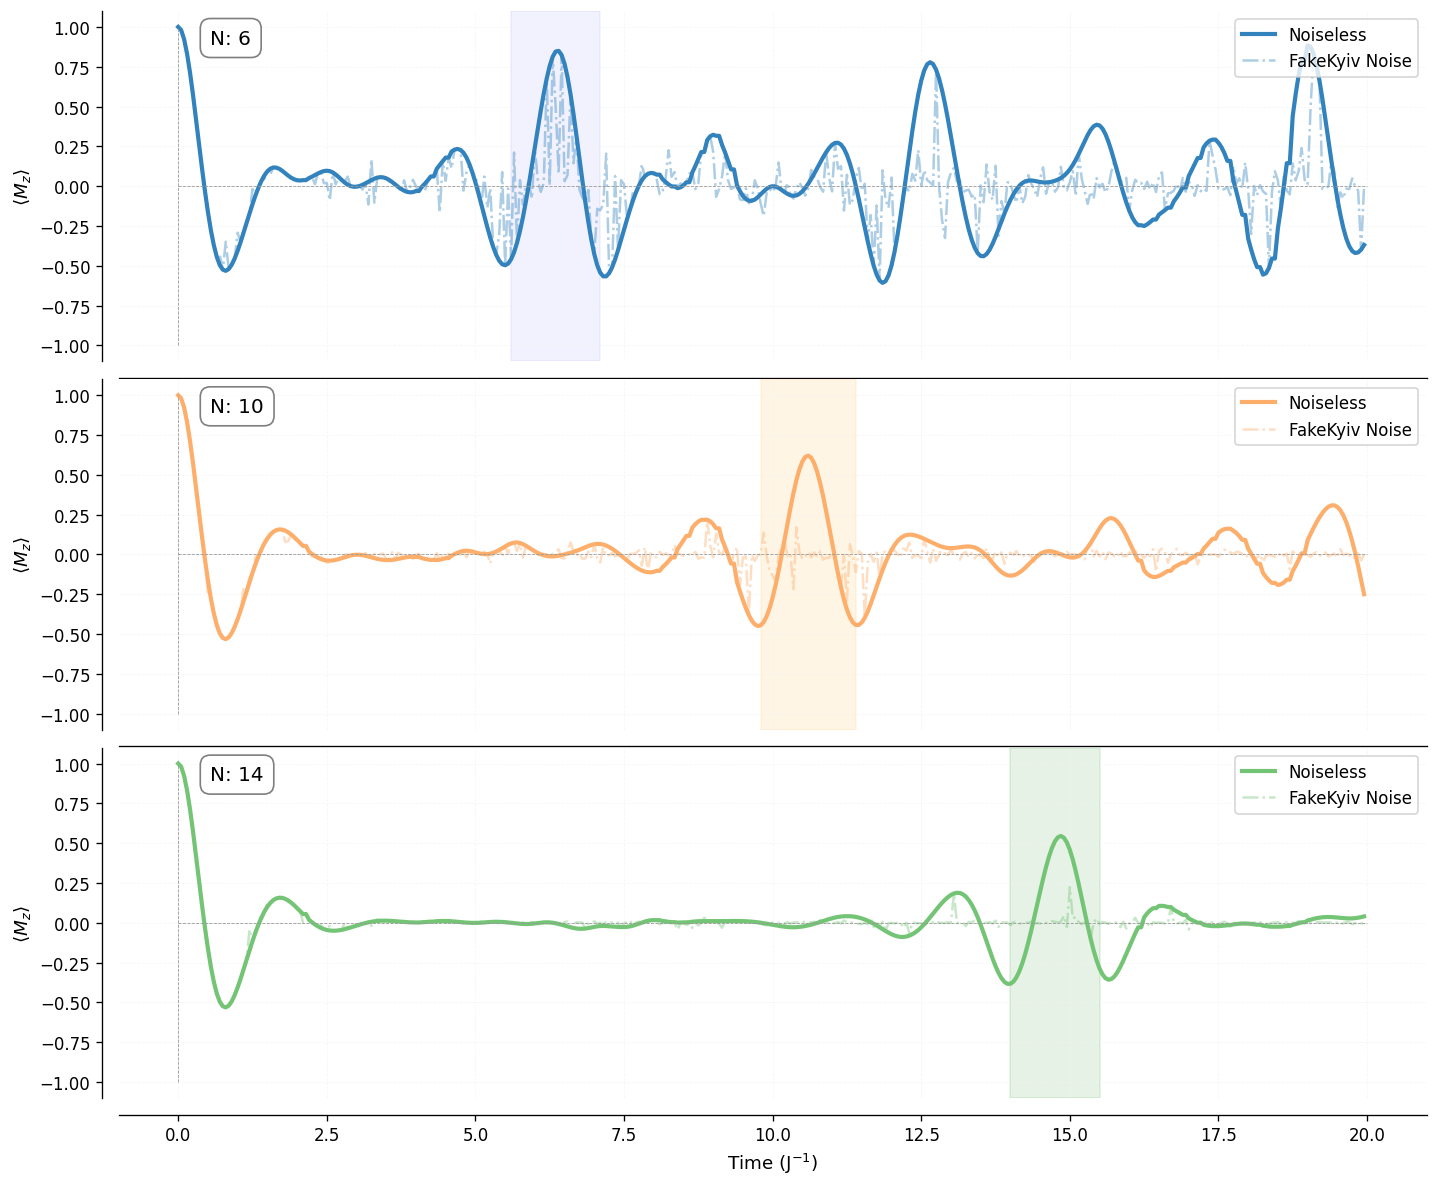

In [170]:
import matplotlib.pyplot as plt

# Function to adjust plot spines
def adjust_spines(ax, visible_spines):
    ax.label_outer(remove_inner_ticks=True)
    ax.grid(color='0.95', linestyle='--', linewidth=0.5)

    for loc, spine in ax.spines.items():
        if loc in visible_spines:
            spine.set_position(('outward', 10))  # Outward by 10 points
        else:
            spine.set_visible(False)

# Define colors using the TAB20c set
colors = plt.get_cmap('tab20c').colors  # Using the TAB20 color palette
markers = ['^', '+', '.', 'o', 's', 'd', 'v']

# Create figure with 3 vertical subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), dpi=120, sharex=True)

# Choose three system sizes to plot (take first three from your results)
system_size1, system_size2, system_size3 = list(results_noiseless.keys())[:3]

# Subplot 1 - First system size (top)
ax1.plot(time_steps, results_noiseless[system_size1],
         color=colors[0], linewidth=2.5, alpha=1, label='Noiseless')
ax1.plot(time_steps, results_noisy[system_size1],
         color=colors[0], linewidth=1.5, linestyle='-.', alpha=0.4, label='FakeKyiv Noise')
ax1.set_ylabel(r'$\langle M_z \rangle$', fontsize=11)
ax1.grid(color='0.95', linestyle='--', linewidth=0.5, alpha=0.7)  # Styled grid
ax1.text(0.07, 0.95, f'N: {system_size1}', transform=ax1.transAxes,
         fontsize=12, verticalalignment='top', color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))  # Box for system size
ax1.axvspan(5.6, 7.1, color='blue', alpha=0.05)
ax1.legend(loc='upper right')  # Consistent legend location
ax1.hlines(0, color='0.6', linestyle='--', linewidth=0.5, xmin=0, xmax=max_time)
ax1.vlines(0, color='0.6', linestyle='--', linewidth=0.5, ymin=-1, ymax=1)
adjust_spines(ax1, ['left', 'bottom'])  # Adjust spines

# Subplot 2 - Second system size (middle)
ax2.plot(time_steps, results_noiseless[system_size2],
         color=colors[6], linewidth=2.5, alpha=1, label='Noiseless')
ax2.plot(time_steps, results_noisy[system_size2],
         color=colors[6], linewidth=1.5, linestyle='-.', alpha=0.4, label='FakeKyiv Noise')
ax2.set_ylabel(r'$\langle M_z \rangle$', fontsize=11)
ax2.grid(color='0.95', linestyle='--', linewidth=0.5, alpha=0.7)  # Styled grid
ax2.text(0.07, 0.95, f'N: {system_size2}', transform=ax2.transAxes,
         fontsize=12, verticalalignment='top', color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))  # Box for system size
ax2.legend(loc='upper right')  # Consistent legend location
ax2.axvspan(9.8, 11.4, color='orange', alpha=0.1)
ax2.hlines(0, color='0.6', linestyle='--', linewidth=0.5, xmin=0, xmax=max_time)
ax2.vlines(0, color='0.6', linestyle='--', linewidth=0.5, ymin=-1, ymax=1)
adjust_spines(ax2, ['left', 'bottom'])  # Adjust spines

# Subplot 3 - Third system size (bottom)
ax3.plot(time_steps, results_noiseless[system_size3],
         color=colors[9], linewidth=2.5, alpha=1, label='Noiseless')
ax3.plot(time_steps, results_noisy[system_size3],
         color=colors[9], linewidth=1.5, linestyle='-.', alpha=0.4, label='FakeKyiv Noise')
ax3.set_xlabel('Time (J$^{-1}$)', fontsize=11)
ax3.set_ylabel(r'$\langle M_z \rangle$', fontsize=11)
ax3.grid(color='0.5', linestyle='--', linewidth=0.5, alpha=0.7)  # Styled grid
ax3.text(0.07, 0.95, f'N: {system_size3}', transform=ax3.transAxes,
         fontsize=12, verticalalignment='top', color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))  # Box for system size
ax3.legend(loc='upper right')  # Consistent legend location
ax3.axvspan(14, 15.5, color='green', alpha=0.1)
ax3.hlines(0, color='0.6', linestyle='--', linewidth=0.5, xmin=0, xmax=max_time)
ax3.vlines(0, color='0.6', linestyle='--', linewidth=0.5, ymin=-1, ymax=1)
adjust_spines(ax3, ['left', 'bottom'])  # Adjust spines

# Overall figure title
plt.tight_layout()
plt.savefig('time-dynamics-with-noise_poster', dpi=600)
plt.show()

### Decoding the linear relationship between system size and time of recurrence

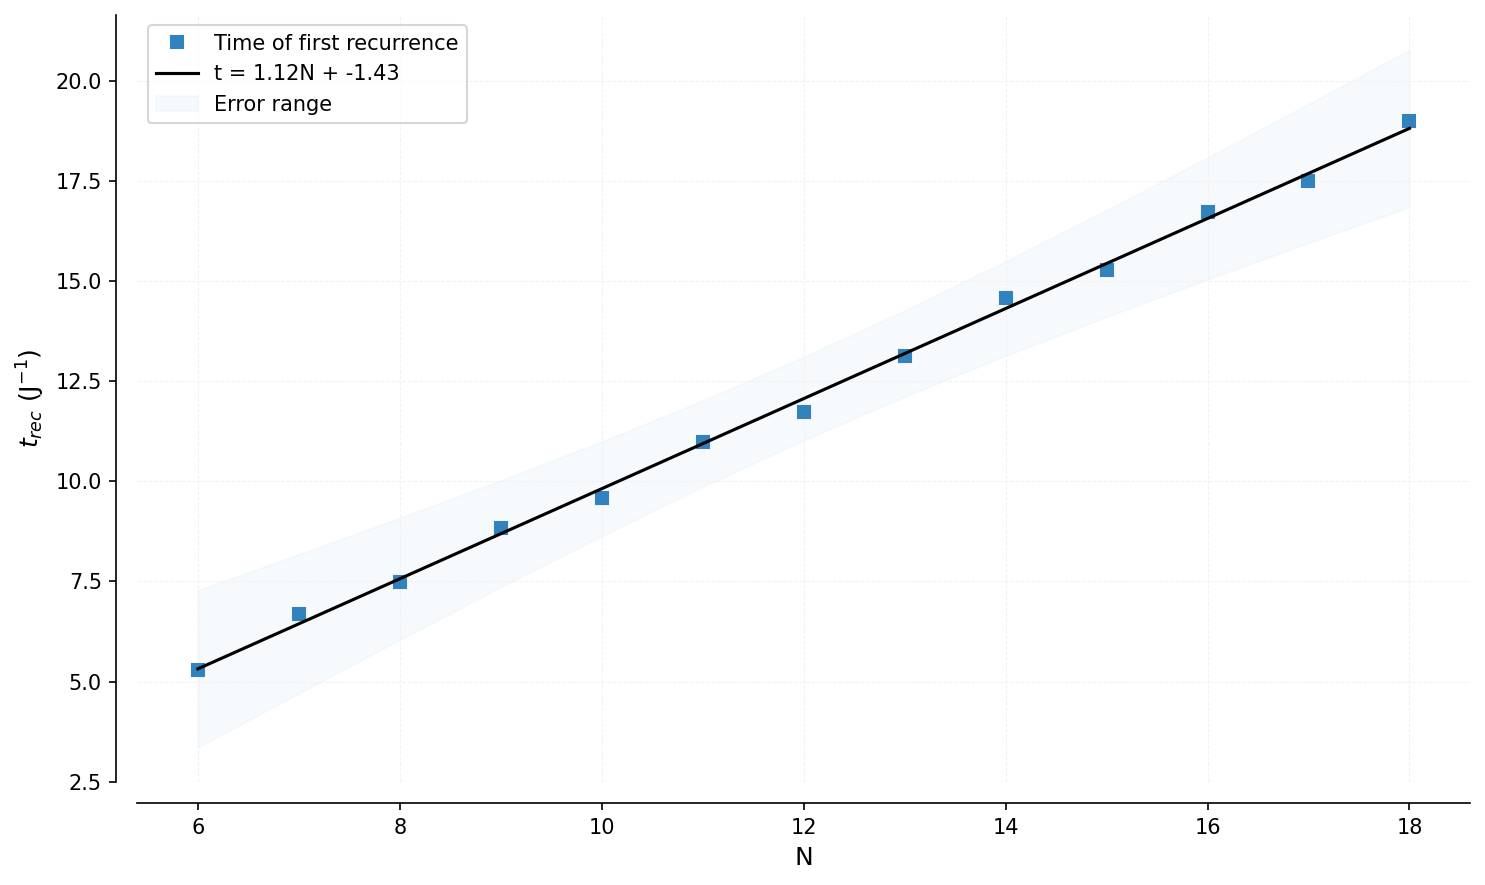

In [169]:

t_revs = [np.float64(5.290000000000001), np.float64(6.69), np.float64(7.490000000000001), np.float64(8.84), np.float64(9.59), np.float64(10.99), np.float64(11.74), np.float64(13.14), np.float64(14.59), np.float64(15.290000000000001), np.float64(16.740000000000002), np.float64(17.490000000000002), np.float64(18.990000000000002)]
N = [6,7,8,9,10,11,12,13,14,15,16,17,18] 

def adjust_spines(ax, visible_spines):
    ax.label_outer(remove_inner_ticks=True)
    ax.grid(color='0.95', linestyle='--', linewidth=0.5)

    for loc, spine in ax.spines.items():
        if loc in visible_spines:
            spine.set_position(('outward', 10))  # Outward by 10 points
        else:
            spine.set_visible(False)


# Convert N to a NumPy array
N = np.array(N)

# Fit a linear curve and estimate y-values and their error
a, b = np.polyfit(N, t_revs, deg=1)
t_est = a * N + b
t_err = N.std() * np.sqrt(1 / len(N) + (N - N.mean())**2 / np.sum((N - N.mean())**2))

# Prepare equation text
equation_text = f't = {a:.2f}N + {b:.2f}'

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(N, t_revs, 's', label='Time of first recurrence', color=colors[0])
ax.plot(N, t_est, 'black', label=equation_text)
ax.fill_between(N, t_est - t_err, t_est + t_err, color=colors[1], alpha=0.05, label='Error range')
ax.set_xlabel('N', fontsize=12)
ax.set_ylabel('$t_{rec}$ (J$^{-1}$)', fontsize=12)
ax.legend()
plt.grid(color='0.95', linestyle='--', linewidth=0.5)
adjust_spines(ax, ['left', 'bottom'])  # Adjust spines
plt.tight_layout()
plt.savefig('t_rev_analysis2', dpi = 600)
plt.show()

### Calculating the velocity of spin correlation from the inverse gradient

In [1]:
speed = 1/1.12
print(speed)


0.8928571428571428


### This is close to the theoretical predicted of ~ 0.94

#### - Next works should use FT to extract exact quasi-particle modes contributing to this velocity.